In [1]:
#from https://stackoverflow.com/a/31434967
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

<h1> Bank Marketing Campaign </h1>

## 1. Import packages and data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import squarify
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

seed=42

In [3]:
df_raw = pd.read_csv(r'DATA\bank.csv')
df_full = df_raw.copy()

## 2. Understand data

1 - **age:** (numeric)<br>
2 - **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education:** (categorical: primary, secondary, tertiary and unknown)<br>
5 - **default:** has credit in default? (categorical: 'no','yes','unknown')<br>
6 - **housing:** has housing loan? (categorical: 'no','yes','unknown')<br>
7 - **loan:** has personal loan? (categorical: 'no','yes','unknown')<br>
8 - **balance:** Balance of the individual.

8 - **contact:** contact communication type (categorical: 'cellular','telephone') <br>
9 - **month:** last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - **duration:** last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>

12 - **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - **previous:** number of contacts performed before this campaign and for this client (numeric)<br>
15 - **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>

Output variable (desired target):<br>
21 - **y** - has the client subscribed a term deposit? (binary: 'yes','no')

In [4]:
df_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df_full.shape

(11162, 17)

No missing values

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Text(0, 0.5, '% Deposited')

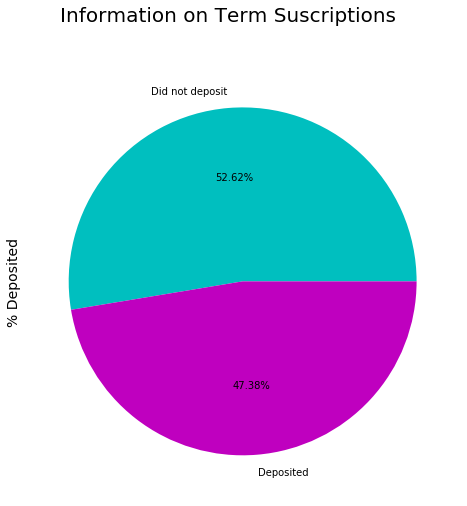

In [7]:
plt.figure(figsize=(16,8))
labels ="Did not deposit", "Deposited"
colors = ['c', 'm']
plt.suptitle('Information on Term Suscriptions', fontsize=20)
plt.pie(df_full["deposit"].value_counts(),autopct='%1.2f%%', labels=labels, colors=colors)
plt.ylabel('% Deposited', fontsize=14)

Distribution of numerical data

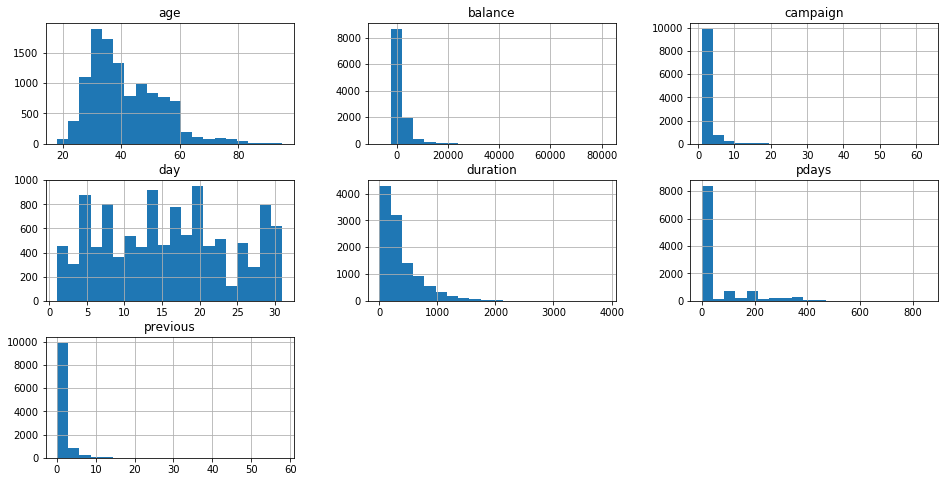

In [8]:
df_full.hist(bins=20, figsize=(16,8))
plt.show()

Hunch is that jobs impact likelihood of subscribing to term deposit.

Let's remove "unknown" job.

In [9]:
df_full = df_full.drop(df_full.loc[df_full.job=="unknown"].index)

And replace "admin" with management since fairly similar.

In [10]:
df_full.job = df_full.job.replace("admin.", "management")

In [11]:
df_full.job.value_counts()

management       3900
blue-collar      1944
technician       1823
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

Let's see correlations

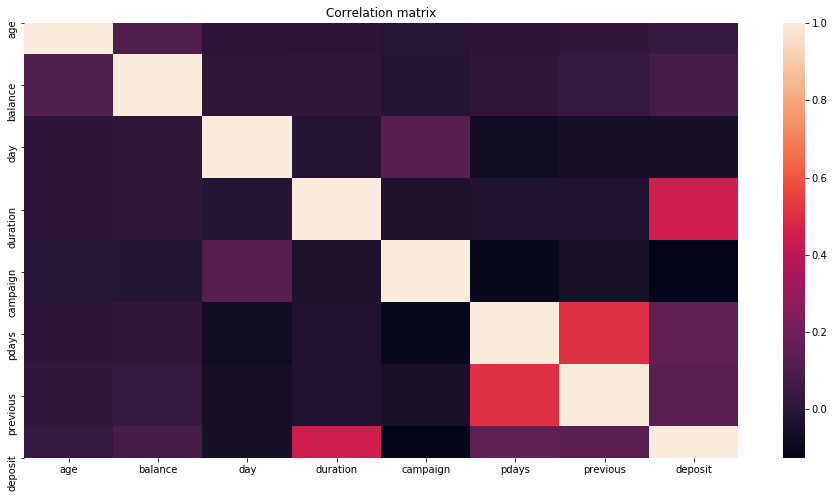

In [12]:
#need to one-hot encode our target variable
from sklearn.preprocessing import LabelEncoder

fig=plt.figure(figsize=(16,8))
df_full.deposit = LabelEncoder().fit_transform(df_full.deposit)

#we can only use numerical features for correlation analysis
numeric_df_full = df_full.select_dtypes(exclude="object")

cor_diagram = numeric_df_full.corr()

sns.heatmap(cor_diagram, cbar=True)
plt.title("Correlation matrix")
plt.show()

From here, we see campaign last contact duration has the highest correlation with whether or not a person subscribes for a deposit.

In [13]:
df_full["duration_status"] = np.nan

avg_duration = df_full["duration"].mean()

df_full["duration_status"] = df_full.apply(lambda row: "below_average" if row.duration<avg_duration else "above_average",axis=1 )

yes_no_by_durationstatus = pd.crosstab(df_full['duration_status'], df_full['deposit']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)
yes_no_by_durationstatus

deposit,0,1
duration_status,,
above_average,22.63,77.37
below_average,68.34,31.66


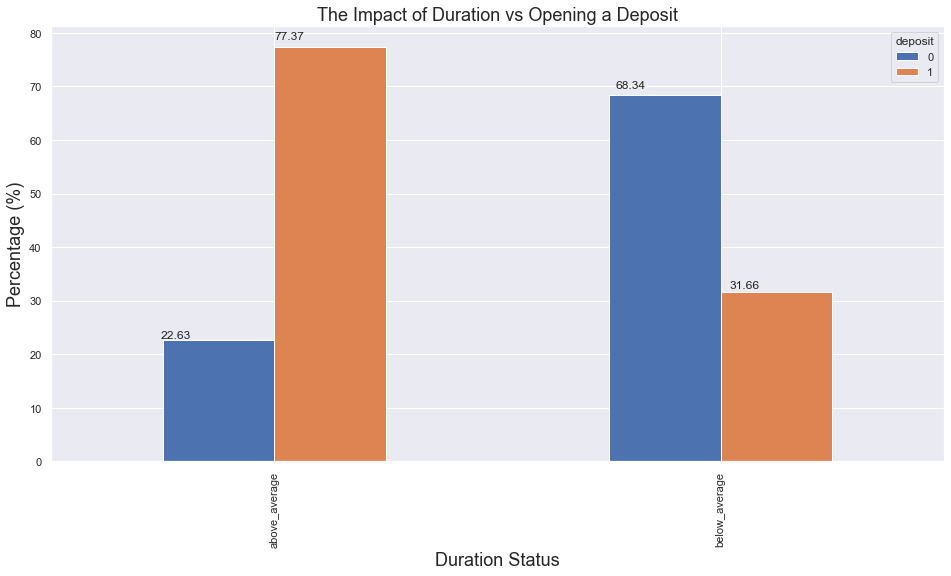

In [14]:
sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_durationstatus.plot(kind='bar', stacked=False)
plt.title("The Impact of Duration vs Opening a Deposit", fontsize=18)
plt.xlabel("Duration Status", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

From here, we see that if you had an above average duration since last campaign, and you were contacted again, majority would subscribe. Conversely, if it hasnt been that long since you were last contacted, and you were contacted again, majority would not subscribe to a deposit.

Probably best to not contact people who have recently been reached out to, focus on those we have not reached out to in a while.

## 3. Model data

In [15]:
df_full = df_raw.copy()

In [16]:
df_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [17]:
df_full[df_full.age.isnull()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit


### Split train - test

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for training_data_indexes, test_data_indexes in stratifier.split(df_full,df_full.loan):
    stratified_training_data = df_full.loc[training_data_indexes]
    stratified_test_data = df_full.loc[test_data_indexes]
    
    
#create copies
train = stratified_training_data.copy()
test = stratified_test_data.copy()

In [19]:
df_full

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [20]:
train.shape

(8929, 17)

In [21]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
9867,55,retired,married,secondary,no,6690,no,no,cellular,30,apr,534,1,-1,0,unknown,no
10647,31,technician,single,secondary,no,433,no,no,cellular,11,aug,1504,2,-1,0,unknown,no
96,30,technician,single,tertiary,no,880,yes,yes,unknown,19,may,967,6,-1,0,unknown,yes
8334,41,services,married,primary,no,0,yes,no,cellular,17,jul,18,11,-1,0,unknown,no
6135,39,housemaid,married,primary,no,13338,no,no,cellular,11,aug,103,4,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3830,53,management,married,tertiary,no,3591,yes,no,cellular,5,aug,306,2,181,2,other,yes
10071,33,admin.,married,secondary,no,920,no,no,cellular,13,aug,111,1,105,1,success,no
2994,31,technician,married,secondary,no,684,yes,no,cellular,7,dec,620,3,-1,0,unknown,yes
335,44,services,married,secondary,no,522,no,yes,unknown,20,jun,911,1,-1,0,unknown,yes


In [22]:
test.shape

(2233, 17)

### Build transformation pipeline

In [23]:
# Definition of the CategoricalEncoder class, copied from kaggle.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8929 entries, 9867 to 9672
Data columns (total 17 columns):
age          8929 non-null int64
job          8929 non-null object
marital      8929 non-null object
education    8929 non-null object
default      8929 non-null object
balance      8929 non-null int64
housing      8929 non-null object
loan         8929 non-null object
contact      8929 non-null object
day          8929 non-null int64
month        8929 non-null object
duration     8929 non-null int64
campaign     8929 non-null int64
pdays        8929 non-null int64
previous     8929 non-null int64
poutcome     8929 non-null object
deposit      8929 non-null object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


In [26]:
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
#numeric_cols.remove('deposit')

In [27]:
numeric_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [28]:
categoric_cols = train.select_dtypes(exclude=np.number).columns.tolist()
#remove target variable, to ensure that we end up with feature set, not label
categoric_cols.remove('deposit')
categoric_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [29]:
# Build pipelines to scale numerical features and encode categorical

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numeric_cols)),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(categoric_cols)),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [30]:
X_train = preprocess_pipeline.fit_transform(train)
X_train

array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [31]:
X_train.shape

(8929, 51)

In [32]:
# do not fit the scaler to test features
X_test = preprocess_pipeline.transform(test)
X_test

array([[-0.44280213, -0.48226862,  1.81287207, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.3936404 , -0.2070024 ,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       [-0.10822512, -0.45913975,  1.57598429, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 3.73941053, -0.08288828, -0.20067412, ...,  0.        ,
         1.        ,  0.        ],
       [-1.36288891,  0.47741694, -1.62200085, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339,  8.29237164,  0.62843314, ...,  0.        ,
         0.        ,  1.        ]])

In [33]:
#instantiatie label from stratified datasets
y_train = train['deposit']
y_test = test['deposit']
y_train.shape

(8929,)

In [34]:
# encode label
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)

### Train using cross-val

In [35]:
#Creat dict of classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict


dict_classifiers = {
    'logistic_reg': LogisticRegression(),
    'support_vector_clf': SVC(),
    'knn_clf': KNeighborsClassifier(),
    'gradient_boosting_clf': GradientBoostingClassifier(),
    'random_forest_cld': RandomForestClassifier(),
    'naive_bayes_clf': GaussianNB(),
    'xgboost_clf': XGBClassifier()
}

dict_preds = {}

for this_classifier in dict_classifiers.keys():
    this_score = cross_val_score(dict_classifiers[this_classifier], X_train, y_train, cv=5)
    # https://stackoverflow.com/questions/25006369/what-is-sklearn-cross-validation-cross-val-score
    this_mean = this_score.mean()
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
    dict_preds[this_classifier] = cross_val_predict(dict_classifiers[this_classifier], X_train, y_train, cv=5) #get predictions, for ROC curve
    print(this_classifier, this_mean)

logistic_reg 0.8265229583719329
support_vector_clf 0.8418654490335585
knn_clf 0.8047939130884586
gradient_boosting_clf 0.8469070896405568
random_forest_cld 0.824279930214951
naive_bayes_clf 0.7192280381654621
xgboost_clf 0.845450883207228


On just rmse evaluation, GB classifier appears to perform the best but only marginally better than an svm.  XGBoost is tops at the moment.

### Evaluate confusion matrix

Plot confusion matrix to see precision and recall. Note the following:

- TN: Those we identified as not taking up a deposit, and in reality did not
- TP: Those we identfied as taking up a deposit, and in reality did
- FN: Those we identified as not taking up a deposit, but in reality did
- FP: Those we identified as taking up a deposit, but in reality did not


  			
- (top row) true positive, false positive
- (bottom row) false negative, true negative

In [36]:
from sklearn.metrics import confusion_matrix
#https://machinelearningmastery.com/confusion-matrix-machine-learning/
 
for this_classifier in dict_preds.keys():
    this_pred = dict_preds[this_classifier]
    confusion_results = confusion_matrix(y_train, this_pred)
    print(this_classifier, "\n\n", confusion_results, "\n\n")

logistic_reg 

 [[4008  689]
 [ 860 3372]] 


support_vector_clf 

 [[3921  776]
 [ 636 3596]] 


knn_clf 

 [[3972  725]
 [1018 3214]] 


gradient_boosting_clf 

 [[3933  764]
 [ 603 3629]] 


random_forest_cld 

 [[3938  759]
 [ 813 3419]] 


naive_bayes_clf 

 [[4032  665]
 [1842 2390]] 


xgboost_clf 

 [[3913  784]
 [ 596 3636]] 




From the above, comparing svm, gb and xgboost, unable to see a clear winner. Both have not insignificant false positives and negatives.

To have a single metric, we can plot a precision-recall curve.

### Evaluate precision-recall using AUC in ROC.

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [37]:
from sklearn.metrics import roc_auc_score

for this_classifier in dict_preds.keys():
    print('{}: {}'.format(this_classifier, roc_auc_score(y_train, dict_preds[this_classifier])))

logistic_reg: 0.8250485066082078
support_vector_clf: 0.8422523043908894
knn_clf: 0.8025489764813883
gradient_boosting_clf: 0.8474285812888651
random_forest_cld: 0.8231498718363046
naive_bayes_clf: 0.7115825348843104
xgboost_clf: 0.8461265949025099


Looking at precision-recall curve, all three are close but gradient boosting_clf is highest. However, given the recent surge in use of xgboost, let's go with this model for now.

### Tune XG Boost

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [38]:
import xgboost as xgb

In [39]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [40]:
from sklearn.metrics import mean_absolute_error

In [41]:
# https://xgboost.readthedocs.io/en/latest/parameter.html
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

params['eval_metric'] = "auc"

num_boost_round = 999

**Set the number of boosting rounds or trees to build, defined by num_boost_round**

If metric has not improved for n number of rounds (defined by early_stopping_rounds), we print the best number of trees to build.

Note, num_boost_round is highly dependent on other hyperparams. Therefore, we will retune this at the end of our various grid-searches.

In [42]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[13:08:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-auc:0.86743
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.878866
[2]	Test-auc:0.885514
[3]	Test-auc:0.893679
[4]	Test-auc:0.896937
[5]	Test-auc:0.902464
[6]	Test-auc:0.904215
[7]	Test-auc:0.907146
[8]	Test-auc:0.908715
[9]	Test-auc:0.908837
[10]	Test-auc:0.910888
[11]	Test-auc:0.91332
[12]	Test-auc:0.914129
[13]	Test-auc:0.913905
[14]	Test-auc:0.915127
[15]	Test-auc:0.915334
[16]	Test-auc:0.915759
[17]	Test-auc:0.915609
[18]	Test-auc:0.915952
[19]	Test-auc:0.915721
[20]	Test-auc:0.915672
[21]	Test-auc:0.916289
[22]	Test-auc:0.916593
[23]	Test-auc:0.916565
[24]	Test-auc:0.917327
[25]	Test-auc:0.917475
[26]	Test-auc:0.917339
[27]	Test-auc:0.917091
[28]	Test-auc:0.916657
[29]	Test-auc:0.917013
[30]	Test-auc:0.917651
[31]	Test-auc:0.918028
[32]	Test-auc:0.918231
[33]	Test-auc:0.917982
[34]	Test-auc:0.917581
[35]	Test-auc:0.917318
[36]	Test-au

Best boosting rounds is 32 ie 32 trees to build.

**Cross-validation**

Initial cv to see baseline AUC.

In [43]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)

cv_results

[13:08:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.895352,0.001029,0.877857,0.006407
1,0.910791,0.002462,0.889958,0.004376
2,0.920619,0.001720,0.897551,0.004856
3,0.927345,0.001723,0.902645,0.004753
4,0.933272,0.000487,0.906412,0.004667
5,0.937635,0.000953,0.908748,0.004062
6,0.942217,0.000453,0.911156,0.003657
7,0.945193,0.000666,0.912237,0.003584
8,0.948804,0.001136,0.913558,0.003307
9,0.951408,0.001344,0.915227,0.003081


AUC for validation set is lower than training set, indicating likely overfitting.

**Gridsearch - Parameters max_depth and min_child_weight:**

Those parameters add constraints on the architecture of the trees.
- **max_depth** is the maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.

- **min_child_weight** is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

In [44]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,9)
    for min_child_weight in range(1,8)
]

In [45]:
# Define initial best params and AUC
# min_mae = float("Inf") # use this if for MAE
max_auc = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max() 
    # mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=6, min_child_weight=1
[13:08:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9226512000000001 for 26 rounds
CV with max_depth=6, min_child_weight=2
[13:08:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is

	AUC 0.9230138 for 22 rounds
CV with max_depth=7, min_child_weight=7
[13:09:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9220010000000001 for 17 rounds
CV with max_depth=8, min_child_weight=1
[13:09:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:15] WARNING: src/objective/regress

In [46]:
params['max_depth'] = 6
params['min_child_weight'] = 3

In [47]:
params

{'max_depth': 6,
 'min_child_weight': 3,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'reg:linear',
 'eval_metric': 'auc'}

**Gridsearch - Parameters subsample and colsample_bytree:**

Those parameters control the sampling of the dataset that is done at each boosting round.
Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

- **subsample** corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.

- **colsample_bytree** corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

In [48]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(1,11)]
    for colsample in [i/10. for i in range(1,11)]
]

In [49]:
max_auc = 0
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max() 
    # mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=1.0, colsample=1.0
[13:09:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9234762 for 26 rounds
CV with subsample=1.0, colsample=0.9
[13:09:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated

	AUC 0.9247728000000001 for 28 rounds
CV with subsample=0.9, colsample=0.7
[13:10:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9219604 for 33 rounds
CV with subsample=0.9, colsample=0.6
[13:10:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:11] WARNING: src/objective/regression_ob

	AUC 0.9205808 for 32 rounds
CV with subsample=0.8, colsample=0.4
[13:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9188561999999999 for 26 rounds
CV with subsample=0.8, colsample=0.3
[13:10:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:45] WARNING: src/objective/regression_ob

	AUC 0.9156091999999999 for 56 rounds
CV with subsample=0.7, colsample=0.1
[13:11:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9073964 for 46 rounds
CV with subsample=0.6, colsample=1.0
[13:11:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:18] WARNING: src/objective/regression_ob

	AUC 0.9184329999999999 for 23 rounds
CV with subsample=0.5, colsample=0.8
[13:11:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9167956 for 21 rounds
CV with subsample=0.5, colsample=0.7
[13:11:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:54] WARNING: src/objective/regression_ob

	AUC 0.9130157999999999 for 18 rounds
CV with subsample=0.4, colsample=0.5
[13:12:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9131883999999999 for 19 rounds
CV with subsample=0.4, colsample=0.4
[13:12:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:25] WARNING: src/objective/regr

	AUC 0.9077904 for 30 rounds
CV with subsample=0.3, colsample=0.2
[13:12:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9036912000000001 for 46 rounds
CV with subsample=0.3, colsample=0.1
[13:12:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:52] WARNING: src/objective/regression_ob

	AUC 0.8950848 for 12 rounds
CV with subsample=0.1, colsample=0.9
[13:13:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.8948157999999999 for 12 rounds
CV with subsample=0.1, colsample=0.8
[13:13:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:12] WARNING: src/objective/regression_ob

In [50]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8

**Gridsearch - Parameters ETA:**

The ETA parameter controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step (remember how each boosting round is correcting the errors of the previous).

In practice, having a lower eta makes our model more robust to overfitting thus, usually, the lower the learning rate, the best. But with a lower eta, we need more boosting rounds, which takes more time to train, sometimes for only marginal improvements. Let's try a couple of values here, and time them with the notebook command:

In [51]:
%time
# This can take some time…

min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max() 
    # mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, max_auc))

Wall time: 0 ns
CV with eta=0.3
Wall time: 0 ns
[13:13:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	AUC 0.9247728000000001 for 28 rounds
CV with eta=0.2
Wall time: 0 ns
[13:13:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is

In [52]:
params['eta'] = 0.01
params

{'max_depth': 6,
 'min_child_weight': 3,
 'eta': 0.01,
 'subsample': 0.9,
 'colsample_bytree': 0.8,
 'objective': 'reg:linear',
 'eval_metric': 'auc'}

**Cross-validation again, to decide on num_boost_rounds**

In [53]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[13:15:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-auc:0.861054
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.880528
[2]	Test-auc:0.883616
[3]	Test-auc:0.885029
[4]	Test-auc:0.890562
[5]	Test-auc:0.890139
[6]	Test-auc:0.891283
[7]	Test-auc:0.890935
[8]	Test-auc:0.88965
[9]	Test-auc:0.890139
[10]	Test-auc:0.889942
[11]	Test-auc:0.891755
[12]	Test-auc:0.891586
[13]	Test-auc:0.891239
[14]	Test-auc:0.891113
[15]	Test-auc:0.891316
[16]	Test-auc:0.89161
[17]	Test-auc:0.891731
[18]	Test-auc:0.892154
[19]	Test-auc:0.892745
[20]	Test-auc:0.892961
[21]	Test-auc:0.892882
[22]	Test-auc:0.893448
[23]	Test-auc:0.893635
[24]	Test-auc:0.893772
[25]	Test-auc:0.893783
[26]	Test-auc:0.894187
[27]	Test-auc:0.894132
[28]	Test-auc:0.895267
[29]	Test-auc:0.895072
[30]	Test-auc:0.89494
[31]	Test-auc:0.895646
[32]	Test-auc:0.895682
[33]	Test-auc:0.895671
[34]	Test-auc:0.896133
[35]	Test-auc:0.896223
[36]	Test-auc

[340]	Test-auc:0.915226
[341]	Test-auc:0.915261
[342]	Test-auc:0.915248
[343]	Test-auc:0.915314
[344]	Test-auc:0.915332
[345]	Test-auc:0.915442
[346]	Test-auc:0.915451
[347]	Test-auc:0.915464
[348]	Test-auc:0.915492
[349]	Test-auc:0.915527
[350]	Test-auc:0.915496
[351]	Test-auc:0.915532
[352]	Test-auc:0.915573
[353]	Test-auc:0.915617
[354]	Test-auc:0.91568
[355]	Test-auc:0.915701
[356]	Test-auc:0.915766
[357]	Test-auc:0.915814
[358]	Test-auc:0.915859
[359]	Test-auc:0.915863
[360]	Test-auc:0.915918
[361]	Test-auc:0.915969
[362]	Test-auc:0.915982
[363]	Test-auc:0.916035
[364]	Test-auc:0.91613
[365]	Test-auc:0.916174
[366]	Test-auc:0.916175
[367]	Test-auc:0.916177
[368]	Test-auc:0.916271
[369]	Test-auc:0.916305
[370]	Test-auc:0.916362
[371]	Test-auc:0.916478
[372]	Test-auc:0.916536
[373]	Test-auc:0.916569
[374]	Test-auc:0.916587
[375]	Test-auc:0.916613
[376]	Test-auc:0.91664
[377]	Test-auc:0.916729
[378]	Test-auc:0.916728
[379]	Test-auc:0.916753
[380]	Test-auc:0.916791
[381]	Test-auc:0.91

[684]	Test-auc:0.921874
[685]	Test-auc:0.921938
[686]	Test-auc:0.921942
[687]	Test-auc:0.921941
[688]	Test-auc:0.921914
[689]	Test-auc:0.921959
[690]	Test-auc:0.921947
[691]	Test-auc:0.921993
[692]	Test-auc:0.922012
[693]	Test-auc:0.922027
[694]	Test-auc:0.922061
[695]	Test-auc:0.922121
[696]	Test-auc:0.922144
[697]	Test-auc:0.922137
[698]	Test-auc:0.92214
[699]	Test-auc:0.922147
[700]	Test-auc:0.922167
[701]	Test-auc:0.922206
[702]	Test-auc:0.922182
[703]	Test-auc:0.922178
[704]	Test-auc:0.922189
[705]	Test-auc:0.922185
[706]	Test-auc:0.922214
[707]	Test-auc:0.922221
[708]	Test-auc:0.922243
[709]	Test-auc:0.922295
[710]	Test-auc:0.922318
[711]	Test-auc:0.922346
[712]	Test-auc:0.922353
[713]	Test-auc:0.922367
[714]	Test-auc:0.922388
[715]	Test-auc:0.922403
[716]	Test-auc:0.922434
[717]	Test-auc:0.922462
[718]	Test-auc:0.922461
[719]	Test-auc:0.922403
[720]	Test-auc:0.922402
[721]	Test-auc:0.922422
[722]	Test-auc:0.922424
[723]	Test-auc:0.922428
[724]	Test-auc:0.922442
[725]	Test-auc:0.

From the above, it looks like we need more rounds to get to the best AUC score on the test set compared to before we did our grid-search but at least we have a higher AUC now.




**Check results model on training set**

Now that we know what our best number of boosting trees are needed, let's retrain the model again before saving.

In [54]:
num_boost_round = model.best_iteration + 1
num_boost_round

804

In [55]:
our_best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[13:16:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-auc:0.861054
[1]	Test-auc:0.880528
[2]	Test-auc:0.883616
[3]	Test-auc:0.885029
[4]	Test-auc:0.890562
[5]	Test-auc:0.890139
[6]	Test-auc:0.891283
[7]	Test-auc:0.890935
[8]	Test-auc:0.88965
[9]	Test-auc:0.890139
[10]	Test-auc:0.889942
[11]	Test-auc:0.891755
[12]	Test-auc:0.891586
[13]	Test-auc:0.891239
[14]	Test-auc:0.891113
[15]	Test-auc:0.891316
[16]	Test-auc:0.89161
[17]	Test-auc:0.891731
[18]	Test-auc:0.892154
[19]	Test-auc:0.892745
[20]	Test-auc:0.892961
[21]	Test-auc:0.892882
[22]	Test-auc:0.893448
[23]	Test-auc:0.893635
[24]	Test-auc:0.893772
[25]	Test-auc:0.893783
[26]	Test-auc:0.894187
[27]	Test-auc:0.894132
[28]	Test-auc:0.895267
[29]	Test-auc:0.895072
[30]	Test-auc:0.89494
[31]	Test-auc:0.895646
[32]	Test-auc:0.895682
[33]	Test-auc:0.895671
[34]	Test-auc:0.896133
[35]	Test-auc:0.896223
[36]	Test-auc:0.896116
[37]	Test-auc:0.896086
[38]	Test-auc:0.896532


[343]	Test-auc:0.915314
[344]	Test-auc:0.915332
[345]	Test-auc:0.915442
[346]	Test-auc:0.915451
[347]	Test-auc:0.915464
[348]	Test-auc:0.915492
[349]	Test-auc:0.915527
[350]	Test-auc:0.915496
[351]	Test-auc:0.915532
[352]	Test-auc:0.915573
[353]	Test-auc:0.915617
[354]	Test-auc:0.91568
[355]	Test-auc:0.915701
[356]	Test-auc:0.915766
[357]	Test-auc:0.915814
[358]	Test-auc:0.915859
[359]	Test-auc:0.915863
[360]	Test-auc:0.915918
[361]	Test-auc:0.915969
[362]	Test-auc:0.915982
[363]	Test-auc:0.916035
[364]	Test-auc:0.91613
[365]	Test-auc:0.916174
[366]	Test-auc:0.916175
[367]	Test-auc:0.916177
[368]	Test-auc:0.916271
[369]	Test-auc:0.916305
[370]	Test-auc:0.916362
[371]	Test-auc:0.916478
[372]	Test-auc:0.916536
[373]	Test-auc:0.916569
[374]	Test-auc:0.916587
[375]	Test-auc:0.916613
[376]	Test-auc:0.91664
[377]	Test-auc:0.916729
[378]	Test-auc:0.916728
[379]	Test-auc:0.916753
[380]	Test-auc:0.916791
[381]	Test-auc:0.916825
[382]	Test-auc:0.916868
[383]	Test-auc:0.916873
[384]	Test-auc:0.91

[687]	Test-auc:0.921941
[688]	Test-auc:0.921914
[689]	Test-auc:0.921959
[690]	Test-auc:0.921947
[691]	Test-auc:0.921993
[692]	Test-auc:0.922012
[693]	Test-auc:0.922027
[694]	Test-auc:0.922061
[695]	Test-auc:0.922121
[696]	Test-auc:0.922144
[697]	Test-auc:0.922137
[698]	Test-auc:0.92214
[699]	Test-auc:0.922147
[700]	Test-auc:0.922167
[701]	Test-auc:0.922206
[702]	Test-auc:0.922182
[703]	Test-auc:0.922178
[704]	Test-auc:0.922189
[705]	Test-auc:0.922185
[706]	Test-auc:0.922214
[707]	Test-auc:0.922221
[708]	Test-auc:0.922243
[709]	Test-auc:0.922295
[710]	Test-auc:0.922318
[711]	Test-auc:0.922346
[712]	Test-auc:0.922353
[713]	Test-auc:0.922367
[714]	Test-auc:0.922388
[715]	Test-auc:0.922403
[716]	Test-auc:0.922434
[717]	Test-auc:0.922462
[718]	Test-auc:0.922461
[719]	Test-auc:0.922403
[720]	Test-auc:0.922402
[721]	Test-auc:0.922422
[722]	Test-auc:0.922424
[723]	Test-auc:0.922428
[724]	Test-auc:0.922442
[725]	Test-auc:0.922433
[726]	Test-auc:0.92247
[727]	Test-auc:0.922522
[728]	Test-auc:0.9

In [56]:
params

{'max_depth': 6,
 'min_child_weight': 3,
 'eta': 0.01,
 'subsample': 0.9,
 'colsample_bytree': 0.8,
 'objective': 'reg:linear',
 'eval_metric': 'auc'}

In [57]:
dict_classifiers['xgboost_clf'] = XGBClassifier(colsample_bytree=0.8, eta=0.01,
                      eval_metric='auc', max_depth=6,
                      min_child_weight=3, objective='reg:linear',
                      subsample=0.9,seed=42)

dict_classifiers

{'logistic_reg': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'support_vector_clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=None,
     shrinking=True, tol=0.001, verbose=False),
 'knn_clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'),
 'gradient_boosting_clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
               

In [58]:
# accuracy
revised_score = cross_val_score(dict_classifiers['xgboost_clf'], X_train, y_train, cv=5)

revised_score.mean()

[13:16:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8604564870156233

In [59]:
revised_preds = cross_val_predict(dict_classifiers['xgboost_clf'], X_train, y_train, cv=5)

[13:16:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [60]:
confusion_results = confusion_matrix(y_train, revised_preds)
confusion_results

array([[3959,  738],
       [ 508, 3724]], dtype=int64)

In [61]:
revised_auc = roc_auc_score(y_train, revised_preds)
revised_auc

0.8614203129295013

In [62]:
#our_best_model.save_model("my_model.model")

## 4) Make predictions

https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

"To make predictions we use the scikit-learn function model.predict().

By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. We can easily convert them to binary class values by rounding them to 0 or 1."

In [63]:
our_best_predictions = our_best_model.predict(dtest)
final_best_predictions = [abs(round(value)) for value in our_best_predictions]
final_best_predictions

[0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0

In [64]:
confusion_results = confusion_matrix(y_test, final_best_predictions)
confusion_results

array([[976, 200],
       [128, 929]], dtype=int64)

In [65]:
revised_auc = roc_auc_score(y_test, final_best_predictions)
revised_auc

0.8544172635941794

In [66]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, final_best_predictions)

0.8531124048365427

## 5) Key features

In [67]:
from xgboost import plot_importance

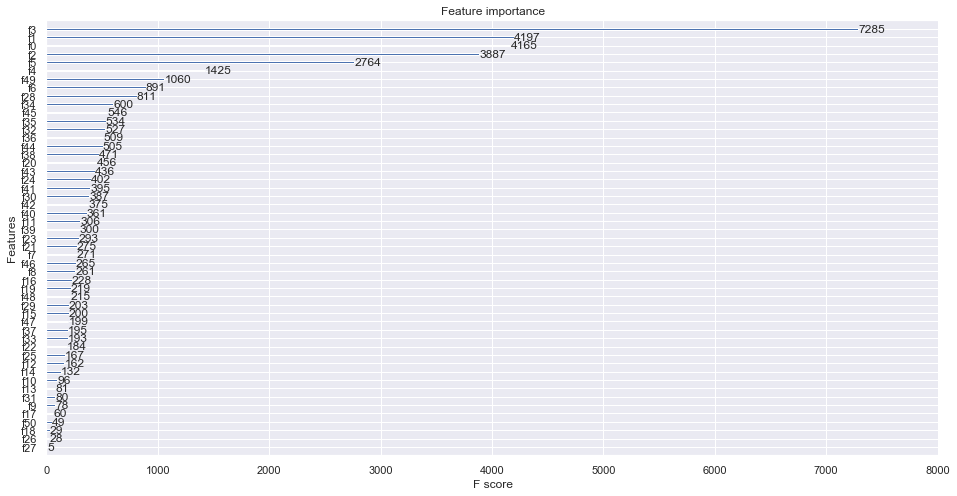

In [68]:
plot_importance(our_best_model)
plt.show()